# Analyzing the Mercari children's book dataset

## Import libraries and files

In [143]:
%matplotlib notebook
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.model_selection import train_test_split

os.chdir('/Users/mleong/github/used-books')
books = pd.read_csv('used-book-data.csv')
books.head()


,brand,category,condition,description,id,posted,price,seller_name,shipping,sold,title
0,NaN,"Other,Books,Children's books",New,Free with another book purchase,84914972647,07/10/17,$3,C Sells,$4.00 | from Texas,Buy now,Book
1,NaN,"Other,Books,Children's books",New,Book-When Bad Thinds Happen in God's Wonderful...,28411714700,07/15/17,$3,Investinyou,$4.00 | 3+ days | from Texas,Buy now,Book- When Bad Things Happen
2,NaN,"Other,Books,Children's books",New,This listing is for one book. Please let me kn...,21933816748,05/26/19,$11,HWalters55,Free | from Washington,Buy now,Usborne Wipe-Clean- NEW
3,NaN,"Other,Books,Children's books",New,Brand new. Never used. Ask me about bundling.,89750511304,11/11/17,$3,Bargain hauls,$4.00 | 3+ days | from Minnesota,Buy now,Jingle Bells Book
4,NaN,"Other,Books,Children's books",New,My Sister The Vampire Vampalicious. New softco...,496308655,08/19/16,$4,Dustyattic,Free | from Connecticut,Buy now,My Sister The Vampire


In [144]:
# Row count
rows = books.shape[0]
print("Number of rows: ", str(rows))

# Column count
columns = books.shape[1]
print("Number of columns: ", str(columns))

# Column names
print("Column names: ", str(books.columns))

# Indexing method
print("Index method: ", str(books.index))

# Data types of all columns
print("Data types for entire dataframe: ")
books.info()

# Data type of particular column
print("Data type of price column specifically is: ", str(books.price.dtype))



Number of rows:  49481
Number of columns:  11
Column names:  Index(['brand', 'category', 'condition', 'description', 'id', 'posted',
       'price', 'seller_name', 'shipping', 'sold', 'title'],
      dtype='object')
Index method:  RangeIndex(start=0, stop=49481, step=1)
Data types for entire dataframe: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49481 entries, 0 to 49480
Data columns (total 11 columns):
brand          25163 non-null object
category       49478 non-null object
condition      49481 non-null object
description    49481 non-null object
id             49481 non-null int64
posted         49481 non-null object
price          49481 non-null object
seller_name    49481 non-null object
shipping       49481 non-null object
sold           49481 non-null object
title          49481 non-null object
dtypes: int64(1), object(10)
memory usage: 4.2+ MB
Data type of price column specifically is:  object


## Clean-up time!

### Fix existing features

In [145]:
# eliminate duplicate rows
books = books.drop_duplicates()

# id: convert to string
books.id = books.id.astype(str)

# posted: convert to datetime
books.posted = pd.to_datetime(books.posted)

# sold: combine buy now and add to cart categories to be 'for sale'
books = books.replace('Buy now', 'available')

# price: modify to eliminate '$' sign and convert to number
books['price'] = books['price'].str.replace(',', '')
books['price'] = books['price'].str.replace('$', '')
books['price'] = books['price'].astype(int)


### And add new ones

In [146]:
# create new column "shipping_cost" that is continuous variable from $0 to whatever shipping fee is
def shipping_cost(shipping_string):
    shipping_after = shipping_string.split(" | ")
    if 'Free' in shipping_after[0]:
        shipping_cost = 0
    elif '$' in shipping_after[0]:
        shipping_cost = shipping_after[0]
        shipping_cost = shipping_cost.replace('$', '') 
    else:
        shipping_cost = None
    return shipping_cost
books['shipping_cost'] = books['shipping'].apply(shipping_cost)
books.shipping_cost = pd.to_numeric(books.shipping_cost, errors='coerce')

# create new simpler column "shipping_time" that is number of days to arrival
def shipping_time(shipping_string):
    if 'days' in shipping_string:
        shipping_after = shipping_string.split(" | ")
        if 'days' in shipping_after[0]:
            shipping_time = shipping_after[0]
            shipping_time = shipping_time.replace('+ days', '')
        elif 'days' in shipping_after[1]:
            shipping_time = shipping_after[1]
            shipping_time = shipping_time.replace('+ days', '')
        else:
            shipping_time = None
    else:
        shipping_time = None
    return shipping_time
books['shipping_time'] = books['shipping'].apply(shipping_time)

# create new simpler column "shipping_location" that is just the state product is coming from
def shipping_location(shipping_string):
    if 'from' in shipping_string:
        shipping_after = shipping_string.split(" | ")
        if 'from' in shipping_after[0]:
            shipping_location = shipping_after[0]
            shipping_location = shipping_location.replace('from ', '')
        elif 'from' in shipping_after[1]:
            shipping_location = shipping_after[1]
            shipping_location = shipping_location.replace('from ', '')
        elif 'from' in shipping_after[2]:
            shipping_location = shipping_after[2]
            shipping_location = shipping_location.replace('from ', '')
        else:
            shipping_location = None
    else:
        shipping_location = None
    return shipping_location
books['shipping_location'] = books['shipping'].apply(shipping_location)

# total price: new column that is sum of price and shipping fee
books['total_price'] = books['price']+books['shipping_cost']

# Making free_shipping column a yes/no
def free_shipping(shipping_cost):
    if shipping_cost == 0:
        free_shipping = 1
    else:
        free_shipping = 0
    return free_shipping

books['free_shipping'] = books.shipping_cost.apply(free_shipping)

# Making brand_included feature thats just a yes or no
books['brand_included'] = books.brand.notnull()
zeroANDones = lambda x: x*1
books.brand_included = books.brand_included.apply(zeroANDones)

# New column sold_true
def sold_true(status):
    if status == 'SOLD':
        sold_true = 1
    else:
        sold_true = 0
    return sold_true
books['sold_true'] = books.sold.apply(sold_true)

# New column summing of description length
def description_length(desc_string):
    description_length = len(desc_string)
    return description_length
books['description_length'] = books.description.apply(description_length)

# New column condition_ordinal from new = 1, like new = 2, good = 3, fair = 4, poor = 5
def condition_ordinal(condition):
    if condition == "New":
        condition_ordinal = 1
    elif condition == "Like new":
        condition_ordinal = 2
    elif condition == "Good":
        condition_ordinal = 3
    elif condition == "Fair":
        condition_ordinal = 4
    elif condition == "Poor":
        condition_ordinal = 5
    else: condition_ordinal = None
    return condition_ordinal
books['condition_ordinal'] = books.condition.apply(condition_ordinal)

# New column days_since_posted. Was scraped on 2019-06-10 so range from 0 and up.
from datetime import date

def days_since_posted(posted):
    posted_day = date(posted.year, posted.month, posted.day)
    scrape_day = date(2019, 6, 10)
    days_since_posted = scrape_day - posted_day
    return days_since_posted.days
books['days_since_posted'] = books.posted.apply(days_since_posted)


In [20]:
books.head()

,brand,category,condition,description,id,posted,price,seller_name,shipping,sold,...,shipping_cost,shipping_time,shipping_location,total_price,free_shipping,brand_included,sold_true,description_length,condition_ordinal,days_since_posted
0,NaN,"Other,Books,Children's books",New,Free with another book purchase,84914972647,2017-07-10,3,C Sells,$4.00 | from Texas,available,...,4.0,None,Texas,7.0,0,0,0,31,1,700
1,NaN,"Other,Books,Children's books",New,Book-When Bad Thinds Happen in God's Wonderful...,28411714700,2017-07-15,3,Investinyou,$4.00 | 3+ days | from Texas,available,...,4.0,3,Texas,7.0,0,0,0,106,1,695
2,NaN,"Other,Books,Children's books",New,This listing is for one book. Please let me kn...,21933816748,2019-05-26,11,HWalters55,Free | from Washington,available,...,0.0,None,Washington,11.0,1,0,0,250,1,15
3,NaN,"Other,Books,Children's books",New,Brand new. Never used. Ask me about bundling.,89750511304,2017-11-11,3,Bargain hauls,$4.00 | 3+ days | from Minnesota,available,...,4.0,3,Minnesota,7.0,0,0,0,47,1,576
4,NaN,"Other,Books,Children's books",New,My Sister The Vampire Vampalicious. New softco...,496308655,2016-08-19,4,Dustyattic,Free | from Connecticut,available,...,0.0,None,Connecticut,4.0,1,0,0,64,1,1025


### Filter to smaller subset of data that is only sold within the past 2 weeks and things that have been availabe for over 2 weeks

In [105]:
books_filtered = books[(books.days_since_posted < 7) & (books.sold_true == 1)]
print("Books sold within the last week: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted < 14) & (books.sold_true == 1)]
print("Books sold within the last 2 weeks: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted < 30) & (books.sold_true == 1)]
print("Books sold within the last month: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted < 180) & (books.sold_true == 1)]
print("Books sold within the last half year: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted < 365) & (books.sold_true == 1)]
print("Books sold within the last year: ", str(books_filtered.shape[0]))

books_filtered = books[(books.sold_true == 1)]
print("Books sold all time: ", str(books_filtered.shape[0]))

# would be cool to make a drop-off curve of how many books get sold after so many days!

Books sold within the last week:  77
Books sold within the last 2 weeks:  154
Books sold within the last month:  240
Books sold within the last half year:  542
Books sold within the last year:  829
Books sold all time:  989


In [107]:
books_filtered = books[(books.sold_true == 0)]
print("All unsold books: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted > 7) & (books.sold_true == 0)]
print("Books usold after a week: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted > 14) & (books.sold_true == 0)]
print("Books usold after 2 weeks: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted > 30)  & (books.sold_true == 0)]
print("Books usold between 30 and 60 days: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted > 180) & (books.sold_true == 0)]
print("Books usold after half a year: ", str(books_filtered.shape[0]))

books_filtered = books[(books.days_since_posted > 365) & (books.sold_true == 0)]
print("Books usold after a year: ", str(books_filtered.shape[0]))

# would be cool to make a drop-off curve of how many books get sold after so many days!

books_filtered = books[((books.days_since_posted > 30) &(books.days_since_posted <60)) & (books.sold_true == 0)]
print("Books usold between 30 and 60 days: ", str(books_filtered.shape[0]))

All unsold books:  21145
Books usold after a week:  19945
Books usold after 2 weeks:  19011
Books usold between 30 and 60 days:  16814
Books usold after half a year:  6526
Books usold after a year:  3299
Books usold between 30 and 60 days:  3038


### Maybe focus on the one month mark (things that have sold within a month and things unsold after a month)

In [108]:
books_subset = books_filtered = books[(((books.days_since_posted > 30) &(books.days_since_posted <60)) & (books.sold_true == 0)) | ((books.days_since_posted < 30) & (books.sold_true == 1))]
books_subset.shape[0]

3278

## Now time for some exploratory statistics!

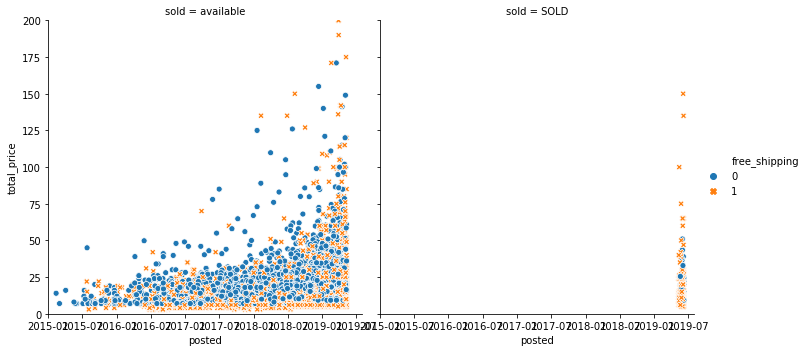

In [91]:
#Total price against date color coded by sold or for sale
# There seem to be a higher proporiton of free shipping purchases to non free shipping purchases in the sold graph!
%matplotlib inline
import seaborn as sns
book_plot = sns.relplot(x="posted", y="total_price", col="sold", hue = "free_shipping", style="free_shipping", data=books)
book_plot.set(xlim=(datetime.date(2015, 1, 1), datetime.date(2019, 8, 1)), ylim=(0,200))
book_plot


In [172]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# books subsets
books_sold = books[books.sold_true == 1]
books_available = books[books.sold_true == 0]

# function to calculate what I want
def cum_books_sold (days):
    cum_books_sold = books_sold[(books_sold.days_since_posted <= days)].shape[0]
    return cum_books_sold
                           

def books_still_left (days):
    books_still_left = books_available.shape[0] - books_available[(books_available.days_since_posted <= days)].shape[0]
    return books_still_left

# creating a dataframe that has data I want to graph
books_over_time = {'Days_since_post': 1:1000}
bot = pd.DataFrame(data=books_over_time)
bot
# matplotlib histogram
#plt.hist(books['days_since_posted'], color = 'blue', edgecolor = 'black', bins = int(180/5))

# seaborn histogram
#sns.distplot(books['days_since_posted'], hist=True, kde=False, bins=int(24), color = 'blue', hist_kws={'edgecolor':'black'})
# Add labels
#plt.title('Histogram of days since posted')
#plt.xlabel('Days since posted')
#plt.ylabel('Number of posts')

SyntaxError: invalid syntax (<ipython-input-172-95a928007389>, line 20)

In [166]:

prop = 989/(21142+989)
print("The proportion of items that sell from total listings:", str(prop), "\nAbout 4.5%")

The proportion of items that sell from total listings: 0.044688446071121955 
About 4.5%


In [92]:
# Can make a new column based on seller data (# of other sales, proportion of sales to posts for seller).
# This doesn't really make sense to include in our model though because it's not something a first time poster 
# can really do anything about.
b = books.groupby('seller_name').count().sort_values(['id'], ascending = False)
b.id

seller_name
Sunshine Rehs Books     203
1uniqueevent            158
twoarrowsbookclub       154
Kcasey46                130
TRACY'S TREASURES       130
Gemini's Bookshelf      108
VACATION  6/8-6/17      106
Educationalmall’s        96
elizabeth6               92
Kelly Harvey             89
Rotamart                 80
lavendersand666          76
TaraMae1981              73
Dominica Taylor          69
jojocloset_a             69
tinytab                  60
Theo's Bookshelf         55
Becca's Bookshelf        55
WheretheSidewalkEnds     54
LokisBooksNMore          54
ParkersClothingMore      52
MeekoPrints              45
Dreamy_Lily              44
Adela                    43
hstewart21158            43
Pmcgriff9998             42
myhouseholdtreasures     38
Tere González            38
Samantha Leach           34
osolover26               34
                       ... 
Lynn.cash                 1
MCrosnoe                  1
Lyn                       1
Lylapacheco               1
Luvin Th

## Modelling Time!

In [116]:
%matplotlib notebook
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

#removing the days_since_posted feature because of subsetting
feature_names_books = ['condition_ordinal', 'price', 'shipping_cost', 'total_price', 'free_shipping', 
                       'brand_included', 'description_length'
                      ]
X_books = books_subset[feature_names_books]
y_books = books_subset['sold_true']

X_train, X_test, y_train, y_test = train_test_split(X_books, y_books, random_state=0)


# Need to look at features and think about whether things needs to be scaled. Shipping location excluded 
# because one hot encoding that does not seem to be worthwhile. I am going to create a condition_ordinal feature scale.
# Also going to create a days_since_posted scale.

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


### Dummy Classifier

In [118]:
from sklearn.dummy import DummyClassifier

dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train_scaled, y_train)
print(dummy_majority.score(X_test_scaled, y_test))

dummy_majority_predicted = dummy_majority.predict(X_test_scaled)
confusion = confusion_matrix(y_test, dummy_majority_predicted)

print('Random class-majoirty prediction (dummy classifier)\n', confusion)

0.9073170731707317
Random class-majoirty prediction (dummy classifier)
 [[744   0]
 [ 76   0]]


### KNN

In [119]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train_scaled, y_train)
print('Accuracy of K-NN classifier on training set: {:.4f}'
     .format(knn.score(X_train_scaled, y_train)))
print('Accuracy of K-NN classifier on test set: {:.4f}'
     .format(knn.score(X_test_scaled, y_test)))

knn_predicted = knn.predict(X_test_scaled)
knn_confusion = confusion_matrix(y_test, knn_predicted)

print('KNN\n', knn_confusion)

Accuracy of K-NN classifier on training set: 0.9353
Accuracy of K-NN classifier on test set: 0.9000
KNN
 [[737   7]
 [ 75   1]]


### Logistic Regression

In [120]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver = 'lbfgs').fit(X_train_scaled, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.4f}'
     .format(logreg.score(X_train_scaled, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.4f}'
     .format(logreg.score(X_test_scaled, y_test)))

logreg_predicted = logreg.predict(X_test_scaled)
logreg_confusion = confusion_matrix(y_test, logreg_predicted)

print('Logistic Regression\n', logreg_confusion)

Accuracy of Logistic regression classifier on training set: 0.9337
Accuracy of Logistic regression classifier on test set: 0.9073
Logistic Regression
 [[744   0]
 [ 76   0]]


### Ridge Regression with Feature Normalization

In [121]:
from sklearn.linear_model import Ridge

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

print('ridge regression linear model intercept: {}'
     .format(linridge.intercept_))
print('ridge regression linear model coeff:\n{}'
     .format(linridge.coef_))
print('R-squared score (training): {:.3f}'
     .format(linridge.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}'
     .format(linridge.score(X_test_scaled, y_test)))
print('Number of non-zero features: {}'
     .format(np.sum(linridge.coef_ != 0)))



ridge regression linear model intercept: -0.0020509068183139217
ridge regression linear model coeff:
[-0.00912713  0.08644587 -0.02165774  0.083832    0.05891775  0.03662781
  0.0144063 ]
R-squared score (training): 0.026
R-squared score (test): 0.015
Number of non-zero features: 7


### SVC

In [122]:
from sklearn.svm import LinearSVC

svc = LinearSVC().fit(X_train_scaled, y_train)
print('Accuracy of Linear SVC classifier on training set: {:.4f}'
     .format(svc.score(X_train_scaled, y_train)))
print('Accuracy of Linear SVC classifier on test set: {:.4f}'
     .format(svc.score(X_test_scaled, y_test)))

svc_predicted = svc.predict(X_test_scaled)
svc_confusion = confusion_matrix(y_test, svc_predicted)

print('SVC \n', svc_confusion)

Accuracy of Linear SVC classifier on training set: 0.9337
Accuracy of Linear SVC classifier on test set: 0.9061
SVC 
 [[743   1]
 [ 76   0]]


### Naive Bayes

In [123]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB().fit(X_train_scaled, y_train)
print('Accuracy of GaussianNB classifier on training set: {:.4f}'
     .format(nb.score(X_train_scaled, y_train)))
print('Accuracy of GaussianNB classifier on test set: {:.4f}'
     .format(nb.score(X_test_scaled, y_test)))

nb_predicted = nb.predict(X_test_scaled)
nb_confusion = confusion_matrix(y_test, nb_predicted)

print('Naive Bayes \n', nb_confusion)

Accuracy of GaussianNB classifier on training set: 0.9154
Accuracy of GaussianNB classifier on test set: 0.8854
Naive Bayes 
 [[724  20]
 [ 74   2]]


### Random Forests

In [132]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(min_samples_split = 10, n_estimators = 1000, random_state=0).fit(X_train_scaled, y_train)
print('Accuracy of RF classifier on training set: {:.4f}'
     .format(rf.score(X_train_scaled, y_train)))
print('Accuracy of RF classifier on test set: {:.4f}'
     .format(rf.score(X_test_scaled, y_test)))

rf_predicted = rf.predict(X_test_scaled)
rf_confusion = confusion_matrix(y_test, rf_predicted)

print('Random Forest \n', rf_confusion)

Accuracy of RF classifier on training set: 0.9365
Accuracy of RF classifier on test set: 0.9073
Random Forest 
 [[743   1]
 [ 75   1]]


### Gradient-Boosted Decision Trees

In [125]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, random_state = 0)
gbdt.fit(X_train_scaled, y_train)
print('(learning_rate=0.01, max_depth=2)')
print('Accuracy of GBDT classifier on training set: {:.4f}'
     .format(gbdt.score(X_train_scaled, y_train)))
print('Accuracy of GBDT classifier on test set: {:.4f}'
     .format(gbdt.score(X_test_scaled, y_test)))

gbdt_predicted = gbdt.predict(X_test_scaled)
gbdt_confusion = confusion_matrix(y_test, gbdt_predicted)

print('Gradient-Boosted Decision Trees \n', gbdt_confusion)

(learning_rate=0.01, max_depth=2)
Accuracy of GBDT classifier on training set: 0.9333
Accuracy of GBDT classifier on test set: 0.9073
Gradient-Boosted Decision Trees 
 [[744   0]
 [ 76   0]]


## Evaluating these metrics with alternative models

In [126]:
from sklearn.metrics import classification_report

print('Dummy predictor (most frequent) \n', classification_report(y_test, dummy_majority_predicted, target_names=['available', 'sold']))
print('KNN \n', classification_report(y_test, knn_predicted, target_names=['available', 'sold']))
print('Logistic regression\n', classification_report(y_test, logreg_predicted, target_names = ['available', 'sold']))
print('SVC\n', classification_report(y_test, svc_predicted, target_names = ['available', 'sold']))
print('Naive Bayes\n', classification_report(y_test, nb_predicted, target_names = ['available', 'sold']))
print('Random Forest\n', classification_report(y_test, rf_predicted, target_names = ['available', 'sold']))
print('Gradient-Boosted Decision Trees\n', classification_report(y_test, gbdt_predicted, target_names = ['available', 'sold']))

Dummy predictor (most frequent) 
               precision    recall  f1-score   support

   available       0.91      1.00      0.95       744
        sold       0.00      0.00      0.00        76

   micro avg       0.91      0.91      0.91       820
   macro avg       0.45      0.50      0.48       820
weighted avg       0.82      0.91      0.86       820

KNN 
               precision    recall  f1-score   support

   available       0.91      0.99      0.95       744
        sold       0.12      0.01      0.02        76

   micro avg       0.90      0.90      0.90       820
   macro avg       0.52      0.50      0.49       820
weighted avg       0.84      0.90      0.86       820

Logistic regression
               precision    recall  f1-score   support

   available       0.91      1.00      0.95       744
        sold       0.00      0.00      0.00        76

   micro avg       0.91      0.91      0.91       820
   macro avg       0.45      0.50      0.48       820
weighted avg 

/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/mleong/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precisio